# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import time
import torch
import torch.optim as optim
from src.models.cnf import CNF
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf, train_realnvp
from src.utils.visualization import (
    Synthetic2DViz,
    MNISTViz,
)
from zuko.flows import RealNVP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)


Using device: cuda


## 1. Dataset 2D

Figure saved to: ../results/figures/02_moons_data.png


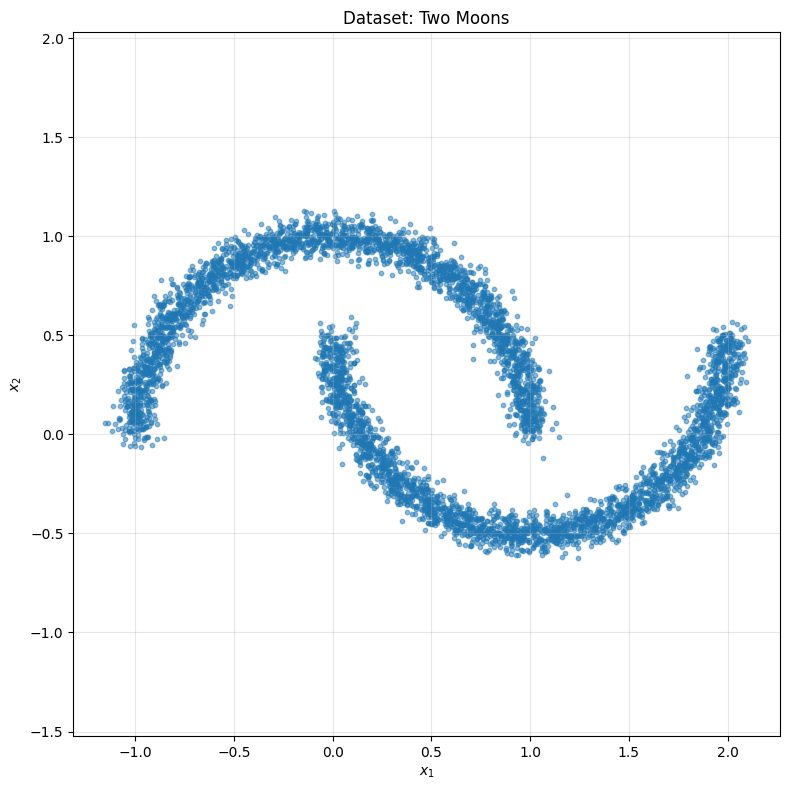

In [2]:
# Criar dataset 2D
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Dataset and model names for file naming
DATASET_2D_NAME = 'moons'

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset_2d.data,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'02_{DATASET_2D_NAME}_data.png')
)
plt.tight_layout()
plt.show()


### 1.1 CNF


In [3]:
# Criar e treinar CNF
MODEL_2D_CNF_NAME = 'cnf'
vf_2d = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d, trace_scale=0.75).to(device)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-2)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, n_epochs=100)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_{MODEL_2D_CNF_NAME}.pt'
)
torch.save(cnf_2d.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

Treinando CNF em dados 2D...


Epoch 1/100: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Epoch 1, Loss: 2.2078


Epoch 2/100: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


Epoch 2, Loss: 2.1167


Epoch 3/100: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 3, Loss: 1.9539


Epoch 4/100: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


Epoch 4, Loss: 1.9094


Epoch 5/100: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 5, Loss: 1.7971


Epoch 6/100: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]


Epoch 6, Loss: 1.7728


Epoch 7/100: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 7, Loss: 1.7220


Epoch 8/100: 100%|██████████| 40/40 [00:19<00:00,  2.09it/s]


Epoch 8, Loss: 1.6800


Epoch 9/100: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


Epoch 9, Loss: 1.6403


Epoch 10/100: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


Epoch 10, Loss: 1.5547


Epoch 11/100: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Epoch 11, Loss: 1.5431


Epoch 12/100: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Epoch 12, Loss: 1.4432


Epoch 13/100:   8%|▊         | 3/40 [00:01<00:24,  1.53it/s]


KeyboardInterrupt: 

#### Visualization

Figure saved to: ../results/figures/02_moons_cnf_transformation.png
Figure saved to: ../results/figures/02_moons_cnf_vector_fields.png
Figure saved to: ../results/figures/02_moons_cnf_vector_fields.png
Figure saved to: ../results/figures/02_moons_cnf_vector_fields.png


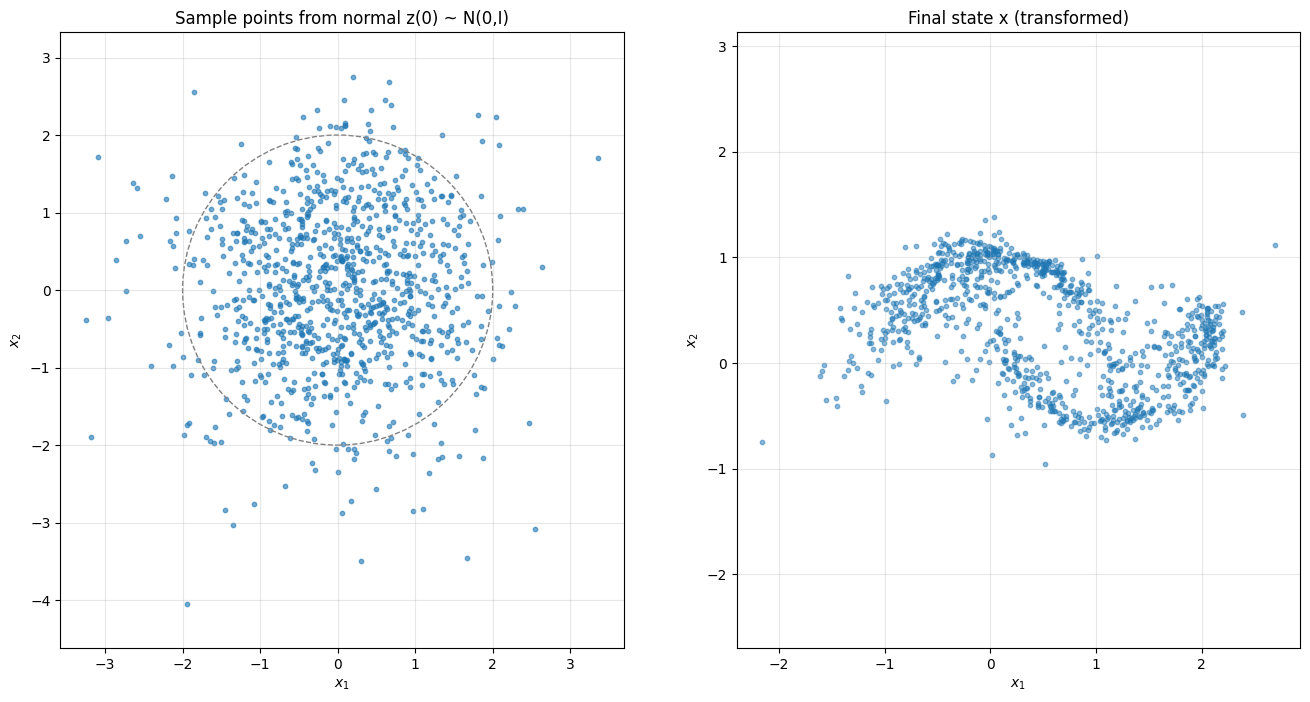

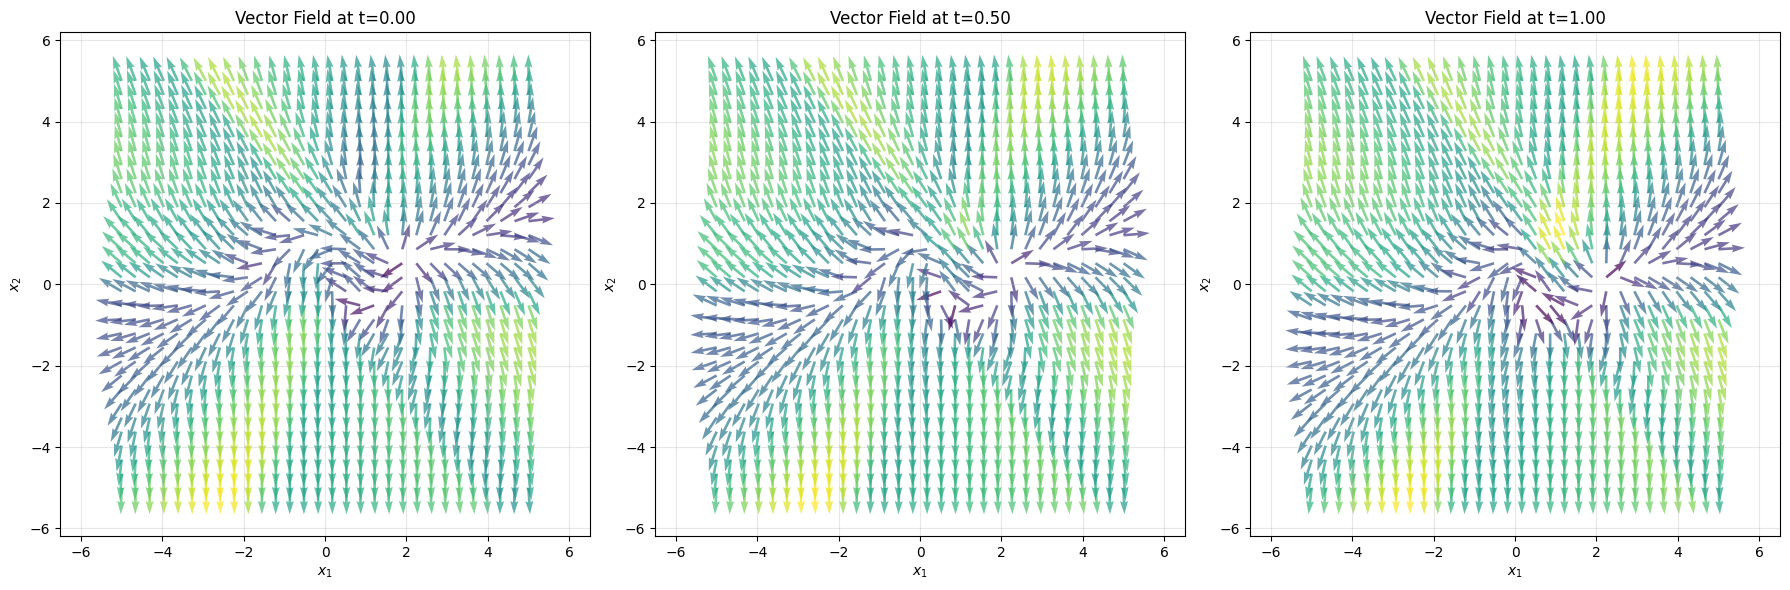

In [7]:
Synthetic2DViz.plot_transformation(
    cnf_2d,
    n_steps=100,
    n_samples=1000,
    save_path=os.path.join(
        FIGURES_DIR,
        f'02_{DATASET_2D_NAME}_{MODEL_2D_CNF_NAME}_transformation.png'
    )
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        cnf_2d,
        xlim=(-5, 5),
        ylim=(-5, 5),
        n_grid=30,
        t=t,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'02_{DATASET_2D_NAME}_{MODEL_2D_CNF_NAME}_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()

### 1.2. RealNVP


In [ ]:
# Criar e treinar RealNVP em dados 2D
MODEL_2D_RNVP_NAME = 'realnvp'
realnvp_2d = RealNVP(
    features=2,
    transforms=4,
    hidden_features=[64, 64]
).to(device)

optimizer_rnvp_2d = optim.Adam(realnvp_2d.parameters(), lr=5e-3)

print("Treinando RealNVP em dados 2D...")
train_realnvp(
    realnvp_2d,
    dataloader_2d,
    optimizer_rnvp_2d,
    device,
    n_epochs=50
)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_{MODEL_2D_RNVP_NAME}.pt'
)
torch.save(realnvp_2d.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
realnvp_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device).to(torch.float32)
    dist = realnvp_2d(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

#### Visualization

In [ ]:
Synthetic2DViz.plot_transformation(
    realnvp_2d,
    n_samples=1000,
    save_path=os.path.join(
        FIGURES_DIR,
        f'02_{DATASET_2D_NAME}_{MODEL_2D_RNVP_NAME}_transformation.png'
    )
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
directions = ['forward', 'inverse', 'forward']
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        realnvp_2d,
        xlim=(-5, 5),
        ylim=(-5, 5),
        t=t,
        n_grid=20,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'02_{DATASET_2D_NAME}_{MODEL_2D_RNVP_NAME}_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()


## 2. MNIST Reduzido

In [ ]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Dataset and model names for file naming
DATASET_MNIST_NAME = 'mnist_reduced'

# Criar e treinar CNF
vf_mnist = VectorField(features=100, hidden_dims=[128, 128], time_embed_dim=32)
cnf_mnist = CNF(vf_mnist, atol=1e-5, rtol=1e-4).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-3)


### 2.1. CNF

In [ ]:

MODEL_MNIST_CNF_NAME = 'cnf'
print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, device, n_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_MNIST_NAME}_{MODEL_MNIST_CNF_NAME}.pt'
)
torch.save(cnf_mnist.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")


#### Visualization

In [ ]:
# Fit PCA on dataset first for consistent projection
MNISTViz.project_to_2d(dataset_mnist.data[:1000], fit_pca=True)
MNISTViz.plot_transformation(
    cnf_mnist,
    n_samples=100,
    data_sample=dataset_mnist.data[:1000]
)
plt.tight_layout()
plt.show()


### 2.2. RealNVP

In [ ]:
# Criar e treinar RealNVP em MNIST reduzido
# RealNVP from zuko: 100 sample features, no context features
realnvp_mnist = RealNVP(
    features=100,
    transforms=4,
    hidden_features=[128, 128]
).to(device)

optimizer_rnvp_mnist = optim.Adam(realnvp_mnist.parameters(), lr=1e-3)

print("Treinando RealNVP em MNIST reduzido...")
start_time = time.time()
train_realnvp(
    realnvp_mnist,
    dataloader_mnist,
    optimizer_rnvp_mnist,
    device,
    n_epochs=5
)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
realnvp_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    dist = realnvp_mnist(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = realnvp_mnist(None).sample((1000,))
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")

#### Visualization

In [ ]:
# Use the same PCA already fitted
MNISTViz.plot_transformation(
    realnvp_mnist,
    n_samples=100,
    data_sample=dataset_mnist.data[:1000]
)
plt.tight_layout()
plt.show()

## 5. Análise de Escalabilidade

**Por que trace exato não escala para MNIST completo (784 dim)?**

- Custo computacional: O(d²) onde d é a dimensão
- Para d=784: precisamos de 784 backward passes
- Cada backward é O(784) → Total O(784²) = O(614,656)
- Isso é muito lento para treinamento prático!

**Solução:** Usar Hutchinson trace estimator (FFJORD) - O(d)
